## Diff. in CNTL and NSC vertical moisture advection 

### Import package

In [48]:
import numpy as np
import xarray as xr
import pickle as pkl

from matplotlib import pyplot as plt

### Load data

In [49]:
# file path
path = "/work/b11209013/2024_Research/MPAS/merged_data/"

# load CNTL data
data = {} # dictionary for saving data

with xr.open_dataset(f"{path}CNTL/w.nc") as f:
    # dimension data
    dims = f.sel(lat=slice(-5, 5)).coords
    
    data["cntl_w"] = f["w"].sel(lat=slice(-5, 5))

with xr.open_dataset(f"{path}CNTL/qv.nc") as f:
    data["cntl_qv"] = f["qv"].sel(lat=slice(-5, 5)) * 1000.
    
# load NSC data
with xr.open_dataset(f"{path}NSC/w.nc") as f:
    data["nsc_w"] = f["w"].sel(lat=slice(-5, 5))
    
with xr.open_dataset(f"{path}NSC/qv.nc") as f:
    data["nsc_qv"] = f["qv"].sel(lat=slice(-5, 5)) * 1000.
    
# load CCKW events
with open("/home/b11209013/Bachelor_Thesis/Major/CCKWs_Selection/CNTL_comp.pkl", "rb") as f:
    cntl_comp = pkl.load(f);

with open("/home/b11209013/Bachelor_Thesis/Major/CCKWs_Selection/NSC_comp.pkl", "rb") as f:
    nsc_comp = pkl.load(f);

sel_lon: dict[str, np.ndarray] = dict(
    cntl=np.array(cntl_comp["sel_lon"]),
    nsc =np.array(nsc_comp["sel_lon"]),
)

sel_time: dict[str, np.ndarray] = dict(
    cntl=np.array(cntl_comp["sel_time"]),
    nsc =np.array(nsc_comp["sel_time"]),
)


### Processing data

In [50]:
# Compute mean moisture
qv_mean = {
    "cntl": data["cntl_qv"].mean({"time", "lat", "lon"}),
    "nsc" : data["nsc_qv"].mean({"time", "lat", "lon"}),
}

# Compute vertical motion with climatology and zonal mean removed
w_rm_cli = {
    "cntl": (data["cntl_w"] - data["cntl_w"].mean({"time", "lon"})).mean({"lat"}),
    "nsc" : (data["nsc_w"]  - data["nsc_w"].mean({"time", "lon"})).mean({"lat"}),
}

### Select data

In [51]:
data_sel = {
    "cntl_w": np.array([
        w_rm_cli["cntl"][i-12:i+12, :, j]
            for i, j in zip(sel_time["cntl"], sel_lon["cntl"])
    ]),
    "nsc_w": np.array([
        w_rm_cli["nsc"][i-12:i+12, :, j]
            for i, j in zip(sel_time["nsc"], sel_lon["nsc"])
    ])
}

print(data_sel["cntl_w"])

[[[-7.91231636e-04 -1.64532883e-03 -2.66830204e-03 ... -1.20559838e-02
   -3.51465563e-03  5.66520495e-03]
  [-2.37546206e-04 -5.53392048e-04 -1.01437257e-03 ... -1.02375764e-02
    8.19321431e-04 -2.90705147e-03]
  [-4.14145965e-04 -9.12761956e-04 -1.70183671e-03 ... -9.03953507e-04
    3.42911622e-03  1.24820785e-04]
  ...
  [ 1.98945665e-04  2.61731999e-04  1.87040889e-04 ... -4.24729381e-03
    4.73962026e-03  3.13528138e-03]
  [ 1.54482346e-04  2.65045208e-04  2.27979937e-04 ...  1.87702174e-03
    6.30840380e-03  3.19063547e-03]
  [-4.91789906e-05 -2.63334718e-04 -7.06200954e-04 ... -5.28311823e-03
   -3.98418354e-03 -5.77584980e-03]]

 [[-3.65959364e-04 -7.73688371e-04 -1.26177561e-03 ... -9.90661327e-03
   -6.54923683e-03 -7.69242877e-03]
  [-4.81421375e-05 -2.81279390e-05  1.03513150e-04 ...  3.42894904e-03
    1.44559512e-04 -2.20569037e-03]
  [ 1.79852912e-04  3.31863499e-04  4.82090662e-04 ...  7.55004352e-03
   -3.10468022e-04 -3.70936608e-03]
  ...
  [ 5.76683029e-04  1.3

### Compute vertical advection

(24, 38)


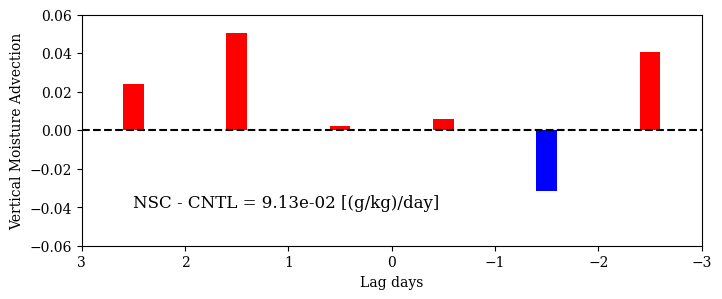

: 

In [ ]:
# Compute vertical moisture gradient
qv_grad = {
    "cntl": np.array((qv_mean["cntl"].differentiate("lev") / 100).values),
    "nsc" : np.array((qv_mean["nsc"].differentiate("lev") / 100).values)
}

# Compute vertical moisture advection
qv_adv = {
    "cntl": (qv_grad["cntl"][None, None, :] * data_sel["cntl_w"]).mean(axis=0),
    "nsc" : (qv_grad["nsc"][None, None, :]  * data_sel["nsc_w"]).mean(axis=0)
}
print(qv_adv["cntl"].shape)
# Construct daily format
daily_qv_adv = {
    "cntl": np.array([qv_adv["cntl"][i*4:(i+1)*4].mean(axis=0) for i in range(6)]).T,
    "nsc" : np.array([qv_adv["nsc"][i*4:(i+1)*4].mean(axis=0) for i in range(6)]).T
}

# Compute vertical integrate
def vert_int(data):
    data_ave = (data[1:] + data[:-1]) / 2.;
    data_vint = -np.sum(data_ave * np.diff(dims["lev"]*100.)[:, None], axis=0) / -np.sum(np.diff(dims["lev"]*100.));
    return data_vint

vert_vadv = {
    "cntl": vert_int(daily_qv_adv["cntl"]),
    "nsc" : vert_int(daily_qv_adv["nsc"])
}

diff = (vert_vadv["nsc"] - vert_vadv["cntl"]) * 86400
pos = np.where(diff >= 0)
neg = np.where(diff <0)

plt.rcParams["font.family"]="serif"
plt.figure(figsize=(8, 3))

plt.bar(np.linspace(-2.5, 2.5, 6)[pos], diff[pos], color="red", width=0.2)
plt.bar(np.linspace(-2.5, 2.5, 6)[neg], diff[neg], color="blue", width=0.2)
plt.axhline(0, linestyle="--", color="black")
plt.xlim(3, -3)
plt.ylim(-0.06, 0.06)
plt.xlabel("Lag days")
plt.ylabel("Vertical Moisture Advection")
plt.savefig("/home/b11209013/Bachelor_Thesis/Major/Figure/Appendix05.png", dpi=300)
plt.text(2.5, -0.04, f"NSC - CNTL = {diff.sum():.2e} [(g/kg)/day]", fontsize=12)
plt.show()
